In [1]:
# 1.標準ライブラリ
import configparser      as cp
import datetime
import glob
import logging
import os
import pprint
import re
import string
import sys
from importlib import import_module

# 2.サードパーティ製ライブラリ
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import psycopg2

# 3.自作ライブラリ
sys.path.append('../')
from mylib.calc_daily_data import calc_daily_data as cd
from mylib.fsc import fsc
from mylib.csv_to_db       import csv_to_db
from mylib.prepro_csv      import prepro_csv as ppc
from mylib.psycopg2_ext    import psycopg2_ext

In [2]:
# 実行パス
path_exe = str(os.getcwd())

# プロジェクトパス
os.chdir(r'..')
path_pro = str(os.getcwd())

# ログの出力名を設定
logger = logging.getLogger('Logging')
 
# ログ出力する最低レベルを設定
logger.setLevel(20)
 
# ログのコンソール出力の設定(する場合は有効化)
# sh = logging.StreamHandler()
# logger.addHandler(sh)
 
# ログのファイル出力先を設定
log_output_time = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
fh = logging.FileHandler(r'{0}\log\{1}.log'.format(path_pro, log_output_time))
logger.addHandler(fh)

# ログの出力形式の設定
formatter = logging.Formatter('%(asctime)s:%(lineno)d:%(levelname)s:%(message)s')
fh.setFormatter(formatter)
# sh.setFormatter(formatter)
logger.log(20, '■START')

# iniファイル読込
config = cp.ConfigParser()
config.read(r'{0}\setting.ini'.format(path_pro))

['D:\\user\\python\\project\\kkb\\setting.ini']

### DBにCSVデータを保存
- Investing.comからダウンロードしたCSVの内容をDWHに書き込む
- 不要な場合はこのセルを実行しない

In [3]:
csv_to_db.csv_to_db(config, logger)

### DBからデータ取得
- SQLは必ず日時の昇順(ASC)でソートすること

In [4]:
# ■入力項目■　ジョブ番号を指定
job_num = "001"

# 対応するデータ加工モジュールをインポート
prc = import_module("mylib.prc_{}.prc_{}".format(job_num,job_num))

# iniファイル読込
job = cp.ConfigParser()
job.read(r'{0}\job\job{1}.ini'.format(path_pro, job_num))

# SQL実行
sql = job['JOB']['SQL_1']
response = pd.DataFrame(psycopg2_ext.execute_sql(logger, config, sql, 'select',''))

# NaNを１つでも含むレコードを全て削除
df = response.dropna(how='any')

# 年月日カラムをDataFrameのインデックスに割当
df = df.set_index(0, drop=True)

### 前処理
- 日次データのまま解析する場合は次のセルは無視
- 週次データにして解析する場合は次のセルを実行

In [5]:
df = cd.calc_day_to_week(df)
df

,1,2,3,4,7,8,9,10,13,14,...,47,48,51,52,53,54,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
2013-12-08 00:00:00+09:00,15300,15748,15794,15113,23762,24020,24050,23532,125,122,...,482,474,0,24,26,24,103,103,103,102
2013-12-15 00:00:00+09:00,15403,15557,15650,15251,23240,23760,24048,22993,122,129,...,480,472,0,26,26,26,103,103,104,102
2013-12-22 00:00:00+09:00,15870,15408,15892,15146,22832,23257,23415,22692,129,123,...,480,469,1,26,27,23,104,103,105,102
2013-12-29 00:00:00+09:00,16179,15956,16233,15849,23278,22922,23295,22911,129,127,...,491,487,0,24,23,24,105,104,105,104
2014-01-05 00:00:00+09:00,16291,16269,16320,16183,23244,23262,23398,23233,127,128,...,496,496,1,23,23,24,105,105,105,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-14 00:00:00+09:00,29388,29095,29426,28932,19599,19999,20286,19520,83,80,...,420,406,-3,16,16,16,136,135,136,134
2023-05-21 00:00:00+09:00,30808,29547,30925,29476,19342,19560,20128,19253,81,84,...,429,406,1,16,22,16,138,136,139,136
2023-05-28 00:00:00+09:00,30801,30736,31353,30558,18624,19352,19750,18536,79,79,...,440,417,1,19,20,19,140,138,140,137


### データ加工

In [6]:
# 関数の実行
train_rc = 200
n_rnn = 15
df_object, df_train, x_test, y_test, x_train, y_train = prc.data_processing(df, train_rc, n_rnn)

### 解析

In [7]:
import keras
from   keras.models            import Sequential
from   keras.layers            import Dense
from   keras.layers.core       import Activation
import tensorflow as tf

- モデル(RNN)

In [8]:
# ■モデルを定義
# x_trainの配列の各要素数が、modelのinput_shapeと一致していること
# y_trainの配列の各要素数が、modelの最後の層のunitと一致していること

from keras.layers import Dense, SimpleRNN
batch_size = 5  # バッチサイズ
n_in       = 40 # 入力層のニューロン数
n_mid      = 80 # 中間層のニューロン数
n_out      = 4  # 出力層のニューロン数

# ①モデル選択
model = Sequential()

# ②入力shapeを指定
model.add(SimpleRNN(n_mid, input_shape=(n_rnn, n_in), return_sequences=True))

# ③中間層を設定
model.add(Dense(n_out, activation="linear"))
# model.add(Dense(n_out, activation="relu"))
model.add( Dense( units = 4 ) )

# ④オプティマイザ選択
optimizer = tf.keras.optimizers.RMSprop(0.1)

# ⑤コンパイル実行
model.compile(loss="mean_squared_error"
#             , optimizer="sgd"
            , optimizer = optimizer
             )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 15, 80)            9680      
                                                                 
 dense (Dense)               (None, 15, 4)             324       
                                                                 
 dense_1 (Dense)             (None, 15, 4)             20        
                                                                 
Total params: 10,024
Trainable params: 10,024
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
6/6 [==============================] - 1s 62ms/step - loss: 302101952.0000 - val_loss: 394153760.0000
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 278036544.0000 - val_loss: 346138720.0000
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 233830736.0000 - val_loss: 289815232.0000
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 186006448.0000 - val_loss: 232058272.0000
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 139632064.0000 - val_loss: 177691216.0000
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 98048800.0000 - val_loss: 128157312.0000
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 62767756.0000 - val_loss: 86762096.0000
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 36083836.0000 - val_loss: 55586892.0000
Epoch 9/100
6/6 [==============================] - 0s 14ms/step - loss: 18551084.0000 - val_l

6/6 [==============================] - 0s 10ms/step - loss: 3196172.5000 - val_loss: 7717373.0000
Epoch 75/100
6/6 [==============================] - 0s 10ms/step - loss: 3522522.7500 - val_loss: 6652139.0000
Epoch 76/100
6/6 [==============================] - 0s 10ms/step - loss: 3294715.2500 - val_loss: 11229482.0000
Epoch 77/100
6/6 [==============================] - 0s 9ms/step - loss: 3217823.5000 - val_loss: 12684781.0000
Epoch 78/100
6/6 [==============================] - 0s 10ms/step - loss: 3442956.5000 - val_loss: 6618449.0000
Epoch 79/100
6/6 [==============================] - 0s 10ms/step - loss: 3347625.2500 - val_loss: 5753236.0000
Epoch 80/100
6/6 [==============================] - 0s 10ms/step - loss: 3098293.2500 - val_loss: 10010238.0000
Epoch 81/100
6/6 [==============================] - 0s 10ms/step - loss: 3251299.0000 - val_loss: 10084395.0000
Epoch 82/100
6/6 [==============================] - 0s 10ms/step - loss: 3214245.5000 - val_loss: 6820636.0000
Epoch 83/10

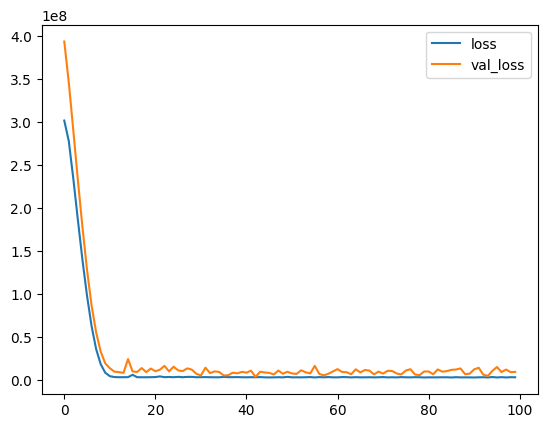

In [9]:
# モデル作成
history = model.fit( x_train, y_train, epochs = 100, batch_size = 30, validation_split=0.2 )
pd.DataFrame(history.history).plot()

# モデルの中身を見る
# model.weights

# モデルの評価
print(model.evaluate(x_test, y_test))

### モデルの保存

In [10]:
# ファイル名用文字列作成
t_delta = datetime.timedelta(hours=9)
JST     = datetime.timezone(t_delta, 'JST')
now     = datetime.datetime.now(JST)\
                  .strftime('%Y-%m-%d_%H%M%S')
# ファイル作成
model.save(r"{0}\keras_model\{1}".format(path_pro, now))

INFO:tensorflow:Assets written to: D:\user\python\project\kkb\keras_model\2023-06-18_153836\assets


INFO:tensorflow:Assets written to: D:\user\python\project\kkb\keras_model\2023-06-18_153836\assets


### モデルの読込
- 作成済みモデルを使う場合はココを実行

In [31]:
model = Sequential()
model = keras.models.load_model(r"{0}\keras_model\2023-03-05_100910".format(path_pro))

### 予測

In [11]:
# ■予測用データ加工
# ★モデル①の場合
# # listを宣言(配列の長さも必要っぽい)
# train = [0]*len(df_train)
# # ・データ型の変更
# i = 0
# while i < len(df_train):
#     train[i] = np.array(df_train.iloc[i,:]).astype(np.float32)
#     i += 1
# # ・kerasに渡す時はndarrayに変換する
# train = np.array(train)

# ★モデル②の場合
train = []
i = 0
while i < len(x_train):
    train.append(x_train[i])
    i += 1

train = np.array(train)

# ・特徴量スケーリング(標準化)
i = 0
for i in range(train.shape[1]):
    train[:,i],  train_mean, train_std  = fsc.zscore(train[:,i])

In [12]:
# モデルを用いて予測データを作成
# pred = model.predict(train[0].reshape(15,40))
pred = model.predict(x_test)

9/9 [==============================] - 0s 3ms/step


In [13]:
# Volume用ダミー
df_dummy = pd.DataFrame([0]*len(pred))

# 予測結果をDataFrame化
# RNNの場合は予測結果データの次元が過剰なので減らす
df_pred = pd.DataFrame([x[0] for x in pred])
df_pred.index = df_train.iloc[n_rnn+1:].index
df_plot = pd.concat([df_object, df_pred], axis=1)
df_plot

,1,2,3,4,0,1,2,3
0,,,,,,,,
2013-12-08 00:00:00+09:00,15300,15748,15794,15113,NaN,NaN,NaN,NaN
2013-12-15 00:00:00+09:00,15403,15557,15650,15251,NaN,NaN,NaN,NaN
2013-12-22 00:00:00+09:00,15870,15408,15892,15146,NaN,NaN,NaN,NaN
2013-12-29 00:00:00+09:00,16179,15956,16233,15849,NaN,NaN,NaN,NaN
2014-01-05 00:00:00+09:00,16291,16269,16320,16183,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-05-14 00:00:00+09:00,29388,29095,29426,28932,16838.767578,16814.431641,17098.146484,16509.982422
2023-05-21 00:00:00+09:00,30808,29547,30925,29476,17436.451172,17411.431641,17704.929688,17095.779297
2023-05-28 00:00:00+09:00,30801,30736,31353,30558,17491.148438,17465.921875,17760.490234,17149.480469


### ①通常の表示形式

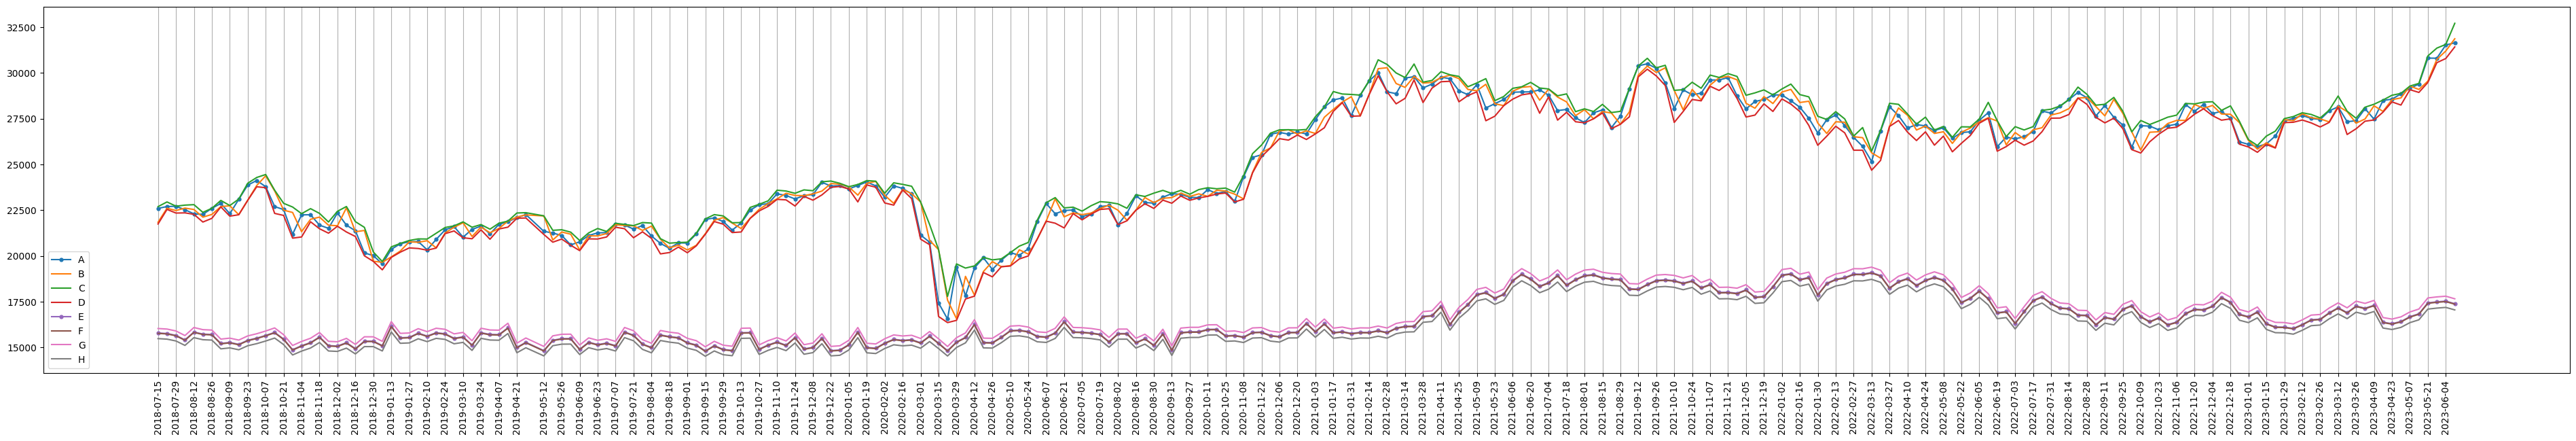

In [14]:
# 表示枠を宣言
fig, ax = plt.subplots(facecolor="w", figsize=(48,7))

# ★表示するX軸範囲を指定
x_min = 240
x_max = 3000
# プロットするデータ
x = df_plot.index[x_min:x_max]
ax.plot(x, df_plot.iloc[x_min:x_max,0], marker='.', markersize=7)
ax.plot(x, df_plot.iloc[x_min:x_max,1])
ax.plot(x, df_plot.iloc[x_min:x_max,2])
ax.plot(x, df_plot.iloc[x_min:x_max,3])
ax.plot(x, df_plot.iloc[x_min:x_max,4], marker='.', markersize=7)
ax.plot(x, df_plot.iloc[x_min:x_max,5])
ax.plot(x, df_plot.iloc[x_min:x_max,6])
ax.plot(x, df_plot.iloc[x_min:x_max,7])

# 軸周り
plt.grid(axis="x")
ax.set_xticks(x[list(range(0,len(df_plot.index[x_min:x_max]),2))])
plt.xticks(rotation=90)

# 凡例
ax.legend(["A", "B", "C", "D","E","F","G","H"]
          , loc = "lower left")

# Note上に表示
plt.show()

# 画像ファイル出力
fig.savefig(r"{0}\keras_model\{1}\{1}".format(path_pro, now))

### ②ローソク足で出力
- mplfinanceのライブラリ仕様に注意
 - DataFrameにすること
 - indexがdatetime型であること
 - カラム数は始値、高値、低値、終値、取引高の５つであること(取引高が無くてもOKっぽい)
 - カラム名は'Open', 'High', 'Low', 'Close', 'Volume'であること

In [15]:
import mplfinance as mpf

# ローソク足用DataFrame作成
df_1 = df_plot.iloc[x_min:x_max,0:4].copy()
df_2 = df_plot.iloc[x_min:x_max,4:].copy()

# Decimalからint
df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_1.columns = ['Open', 'High', 'Low', 'Close']
df_2.columns = ['Open', 'High', 'Low', 'Close']

# 出力
os.chdir(os.path.join(path_pro,"candlestick_chart"))
mpf.plot(df_1, savefig='.\\test1.png')
mpf.plot(df_2, savefig='.\\test2.png')

### データ加工処理（整理中）

In [ ]:
# x_train,y_train(説明変数・目的変数)に用いるカラムを選択
# ついでに件数も指定(元データをモデル作成用と予測テスト用に分ける)

# ■入力項目■
# object_col : 目的変数のカラム番号を指定
# ※他は全て説明変数にするので、外したいカラムはpopするか
#   そもそもSQLで取らないこと
object_col = set([0,1,2,3])
train_col  = set(range(len(df.columns))) ^ object_col
object_col = list(object_col)
train_col  = list(train_col)

# ■入力項目■
# train_rc : 学習用データに使用するレコード数を指定
all_rc   = len(df)
train_rc = 200
test_rc  = all_rc - train_rc

# 後で比較に使用するために目的変数のDataFrameを退避させておく
df_object = df.iloc[:,object_col]
df_train  = df.iloc[train_rc:,train_col]

# 目的変数カラムの値を過去方向に１レコードずらす
# ・前日の説明変数と、今日の目的変数を紐づける
for i in range(len(object_col)):
    df[df.columns[object_col[i]]] = df[df.columns[object_col[i]]].shift(-1)

# ずらしてNanが生じたレコードを削除
df = df.dropna(axis=0, how='any')

# 学習用・検証用データセット作成
df_x_train = df.iloc[0:train_rc,train_col]
df_y_train = df.iloc[0:train_rc,object_col]
df_x_test  = df.iloc[train_rc:,train_col]
df_y_test  = df.iloc[train_rc:,object_col] # 検証用データはずらす前に作った方がよい？検討中(2023-02-18)
df_index   = df_x_test.index

# ■予測用データ加工
# kerasに渡すためにndarrayに変換する

# 書き換え用listを宣言(要素数分の配列長が必要)
x_train = [0]*len(df_x_train)
y_train = [0]*len(df_y_train)
x_test  = [0]*len(df_x_test)
y_test  = [0]*len(df_y_test)

i = 0
while i < len(df_x_train):
    x_train[i] = np.array(df_x_train.iloc[i,:]).astype(np.float32)
    y_train[i] = np.array(df_y_train.iloc[i,:]).astype(np.float32)
    i += 1

i = 0
while i < len(df_x_test):
    x_test[i] = np.array(df_x_test.iloc[i,:]).astype(np.float32)
    i += 1

i = 0
while i < len(df_y_test):
    y_test[i] = np.array(df_y_test.iloc[i,:]).astype(np.float32)
    i += 1

# kerasに渡す時はndarrayに変換する
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test  = np.array(x_test)
y_test  = np.array(y_test)

In [ ]:
# RNN用処理
# ・timestepsぶんのずらしデータを作成
n_rnn    = 15  # 時系列の数
n_sample = len(df)-n_rnn  # サンプル数
df_x = pd.DataFrame([])
df_y = pd.DataFrame([])

for i in range(0, n_sample):
    df_x = pd.concat([df_x, df.iloc[i:i+n_rnn,train_col]])
    df_y = pd.concat([df_y, df.iloc[i+1:i+n_rnn+1,object_col]])
    # i_data[i] = sin_data[i:i+n_rnn]
    # c_data[i] = sin_data[i+1:i+n_rnn+1]  # 時系列を入力よりも一つ後にずらす

# i_data = i_data.reshape(n_sample, n_rnn, 1)  # KerasにおけるRNNでは、入力を（サンプル数、時系列の数、入力層のニューロン数）にする
# c_data = c_data.reshape(n_sample, n_rnn, 1)  # 今回は入力と同じ形状
ary_x = df_x.to_numpy().reshape(n_sample, n_rnn, len(df_x.columns))
ary_y = df_y.to_numpy().reshape(n_sample, n_rnn, len(df_y.columns))

# 学習用・検証用データセット作成
x_train = ary_x[0:train_rc]
y_train = ary_y[0:train_rc]
x_test  = ary_x[train_rc:]
y_test  = ary_y[train_rc:]

# Decimal型は禁止なので変換
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test  = x_test.astype(np.float32)
y_test  = y_test.astype(np.float32)

In [ ]:
# 逆変換用のパラメータを記憶
y_train_sol = [0,0]
y_train_sol = [y_train[:,0].mean(axis=None, keepdims=True)
               , np.std(y_train[:,0], axis=None, keepdims=True)]

# 特徴量スケーリング(標準化) (https://aiacademy.jp/texts/show/?id=555)
def zscore(x, axis = None):
    x_mean  = x.mean(axis=axis, keepdims=True) # 平均
    x_std   = np.std(x, axis=axis, keepdims=True) # 標準偏差
    z_score = (x-x_mean)/x_std # 標準誤差
    return z_score, x_mean, x_std

for i in range(x_train.shape[1]):
    x_train[:,i], x_train_mean, x_train_std = zscore(x_train[:,i])
# for i in range(y_train.shape[1]):
#     y_train[:,i], y_train_mean, y_train_std = zscore(y_train[:,i])
for i in range(x_test.shape[1]):
    x_test[:,i],  x_test_mean, x_test_std  = zscore(x_test[:,i])

In [ ]:
# ■モデルを定義
# x_trainの配列の各要素数が、modelのinput_shapeと一致していること
# y_trainの配列の各要素数が、modelの最後の層のunitと一致していること
# Decimal型はNG

# ①モデル選択
model = Sequential()

# ②入力shapeを指定
model.add( Dense( units = 4, input_shape = (x_train.shape[1],) ) )

# ③中間層を設定
model.add( Activation('relu'))
model.add( Dense( units = 64 ) )
# model.add( Dense( units = 64 ) )
# model.add( Dense( units = 64 ) )
model.add( Dense( units = 64 ) )
model.add( Dense( units = y_train.shape[1] ) )

# ④オプティマイザ選択
optimizer = tf.keras.optimizers.RMSprop(0.01)

# ⑤コンパイル実行
model.compile(loss = 'mse',
              optimizer = optimizer,
              metrics = ['mae', 'mse'])
model.summary()